# ELT GPS Retroescavadeira
## 1. Extract
1.1. If dont have parquet file it will come from gsheet
## 2.Load
2.1. Load and convert in df pandas
## 3. Transform
3.1. Normalize de dataframe


Nestre exemplo os dados coletados em 2022 fornecidos pelo gps da retroscavadeira JCB 3CX, foram armazenados em um unico arquivo em formato de gsheet. Este estudo tem por finalidade **obter informação** utilizando tecnica da engenharia de dados

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import extrair as extrair
import funcoes_gps as funcoes_gps
import filtros as filtros

In [8]:
try: 
    file = 'data/bronze_jcb_relatorio_2022.parquet'
    df = pd.read_parquet(file)
    display('df from:'+file)
except:
    dic = extrair.json_to_dic('variaveis.json')
    display(display(dic['gsheet']['jcb_relatorio_amostra']))

    df = extrair.gsheet_to_df(
        id=dic['gsheet']['jcb_relatorio_2022']['id'],
        tabela=dic['gsheet']['jcb_relatorio_amostra']['tabela'],
        testar=False)
    df.to_parquet(file)
    display('df from: gsheet')
display(df.head(5))

'df from:data/bronze_jcb_relatorio_2022.parquet'

,id,data_hora,hyperlink,atividade,maps_google_url,gps_ativo
0,1,1/1/2022 11:56:00,"=HYPERLINK(""http://maps.google.com/?q=-25,5707...",Estado Activo,"(""http://maps.google.com/?q=-25,5707582,-49,19...",False
1,2,1/1/2022 11:56:00,"=HYPERLINK(""http://maps.google.com/?q=-25,5707...",Ligado,"(""http://maps.google.com/?q=-25,5707582,-49,19...",False
2,3,1/1/2022 11:58:00,"=HYPERLINK(""http://maps.google.com/?q=-25,5707...",GSM Diagnostics-pt,"(""http://maps.google.com/?q=-25,5707582,-49,19...",False
3,4,1/1/2022 11:58:00,"=HYPERLINK(""http://maps.google.com/?q=-25,5707...",Primeiro Acerto do GPS,"(""http://maps.google.com/?q=-25,5707972,-49,19...",True
4,5,1/1/2022 11:59:00,"=HYPERLINK(""http://maps.google.com/?q=-25,5708...",GSM Diagnostics-pt,"(""http://maps.google.com/?q=-25,5708027,-49,19...",True


In [9]:
def df_silver_a(remover_colunas:list,df)->pd.DataFrame:
  """
	converter: data, hora e latitude e longitude
	obter colual: hora, nome_dia,lat_lon
  """
  df['data_hora'] = pd.to_datetime(df['data_hora'], format='%m/%d/%Y %H:%M:%S')
  df['hora'] = df['data_hora'].dt.hour
  df['nome_dia'] = df['data_hora'].dt.day_name().str.lower()

  df['lat'], df['lon'] = zip(*df['maps_google_url'].apply(funcoes_gps.url_to_coordenadas))
  df['lat_lon'] = df['lat'].astype(str) + '|' + df['lon'].astype(str)

  #converter colunas em string
  colunas_str ={'nome_dia': 'string','lat_lon':'string','atividade':'string'}
  df.astype(colunas_str).dtypes

  #remover colunas
  for coluna in remover_colunas:
    if coluna in df.columns:
      df = df.drop(coluna,axis=1)

  return df

remover_colunas = ['id','hyperlink','maps_google_url']
df1 = df_silver_a(df=df,remover_colunas=remover_colunas)

display(df1.head(5))

,data_hora,atividade,gps_ativo,hora,nome_dia,lat,lon,lat_lon
0,2022-01-01 11:56:00,Estado Activo,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
1,2022-01-01 11:56:00,Ligado,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
2,2022-01-01 11:58:00,GSM Diagnostics-pt,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
3,2022-01-01 11:58:00,Primeiro Acerto do GPS,True,11,saturday,-25.570797,-49.196098,-25.5707972|-49.1960976
4,2022-01-01 11:59:00,GSM Diagnostics-pt,True,11,saturday,-25.570803,-49.196095,-25.5708027|-49.1960953


In [10]:
def normalizar_nomes(nomes:list)->list:
  """
  substituir espaço por "_"
  converter tudo em minusculo
  """
  nomes = [nome.lower() for nome in nomes]
  nomes = [nome.replace(' ', '_') for nome in nomes]
  return nomes

atividades = df['atividade'].unique().tolist()
atividades_normalizada = normalizar_nomes(atividades)

for i,atividade in enumerate(atividades):
  df1['atividade'] = df1['atividade'].replace(atividade, atividades_normalizada[i])

df1.head(5)

,data_hora,atividade,gps_ativo,hora,nome_dia,lat,lon,lat_lon
0,2022-01-01 11:56:00,estado_activo,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
1,2022-01-01 11:56:00,ligado,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
2,2022-01-01 11:58:00,gsm_diagnostics-pt,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
3,2022-01-01 11:58:00,primeiro_acerto_do_gps,True,11,saturday,-25.570797,-49.196098,-25.5707972|-49.1960976
4,2022-01-01 11:59:00,gsm_diagnostics-pt,True,11,saturday,-25.570803,-49.196095,-25.5708027|-49.1960953


### salvar Silver
dataframe normalizado

In [11]:
caminho = 'C:\\Users\\User\\Documents\\GitHub\\produtividade_maquina\\data\\' 
arquivo = 'silver_jcb_relatorio_2022.parquet'
df1.to_parquet(caminho+arquivo, index=False)

In [21]:
# filtrar por data
df2 = filtros.df_periodo(df1,'2022-01-01','2022-02-01')
display(df2)
    

,data_hora,atividade,gps_ativo,hora,nome_dia,lat,lon,lat_lon
0,2022-01-01 11:56:00,estado_activo,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
1,2022-01-01 11:56:00,ligado,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
2,2022-01-01 11:58:00,gsm_diagnostics-pt,False,11,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449
3,2022-01-01 11:58:00,primeiro_acerto_do_gps,True,11,saturday,-25.570797,-49.196098,-25.5707972|-49.1960976
4,2022-01-01 11:59:00,gsm_diagnostics-pt,True,11,saturday,-25.570803,-49.196095,-25.5708027|-49.1960953
...,...,...,...,...,...,...,...,...
1317,2022-01-31 16:33:00,em_andamento,True,16,monday,-26.603324,-51.097603,-26.6033236|-51.0976028
1318,2022-01-31 16:40:00,chave_desligada,True,16,monday,-26.603269,-51.097711,-26.6032686|-51.0977108
1319,2022-01-31 16:40:00,paragem_do_motor,True,16,monday,-26.603269,-51.097711,-26.6032686|-51.0977108
1320,2022-01-31 16:55:00,prestes_a_entrar_em_estado_de_descanso,True,16,monday,-26.603250,-51.097703,-26.6032498|-51.0977033


In [13]:
def df_analise(df:pd.DataFrame)->dict:
    """
    analisar conteudo dataframe
    """
    dic = {}
    if df.isna().sum().sum()==0:
        dic['nulos'] = 'Sem valores Nulos'
    else:
        dic['nulos'] = df.isna().sum()

    dic['duplicados'] = df.duplicated().sum()
    dic['tipo_dados'] = df.dtypes
    dic['objetos'] = df.select_dtypes(include=['object']).columns
    return dic

dic = df_analise(df1)

for k,v in dic.items():
    display('-'*30)
    display(k,v)


'------------------------------'

'nulos'

'Sem valores Nulos'

'------------------------------'

'duplicados'

293

'------------------------------'

'tipo_dados'

data_hora    datetime64[ns]
atividade            object
gps_ativo              bool
hora                  int64
nome_dia             object
lat                 float64
lon                 float64
lat_lon              object
dtype: object

'------------------------------'

'objetos'

Index(['atividade', 'nome_dia', 'lat_lon'], dtype='object')

In [14]:
#conhecer atividades disponiveis 
df1['atividade'].unique()

array(['estado_activo', 'ligado', 'gsm_diagnostics-pt',
       'primeiro_acerto_do_gps', 'prestes_a_entrar_em_estado_de_descanso',
       'gsm_metrics-pt', 'chave_ligada', 'arranque_do_motor',
       'chave_desligada', 'paragem_do_motor', 'em_andamento',
       'sem_potência', 'relatório_atempado',
       'routine_data_transmission-pt', 'parado',
       'a_ser_rebocado_(ou_o_sinal_da_ignição_não_funciona)',
       'entrada_de_distância'], dtype=object)

### encontrar o quando a maquina esteve em operação
1. horario
2. dia da semana

{'dia': {'query': '7<=hora<=17', 'qtd': 11900, '%': 98.48, 'ativo': 1}}

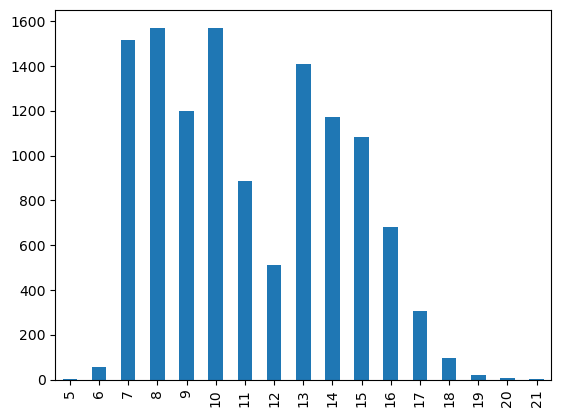

In [15]:
def turno_atividade(atividade:str,df:pd.DataFrame)->dict:
    """
    Encontrar o horario de operação de uma atividade:   
    """
    df1 = df.query(f'atividade =="{atividade}"')
    total_linhas = df1.shape[0]
    
    turnos = {
        'magrudada':{'query':'0<=hora<=6','qtd':0,'%':0},
        'dia':{'query':'7<=hora<=17','qtd':0,'%':0},
        'noite':{'query':'18<=hora<=23','qtd':0,'%':0},
        }
    for k,v in turnos.items():
        turnos[k]['qtd'] = len(df1.query(v['query']))
        turnos[k]['%'] = round((turnos[k]['qtd']/total_linhas)*100,2)
        turnos[k]['ativo']= 1 if turnos[k]['%']>5 else 0
    
    df1['hora'].value_counts().sort_index(ascending=True).plot(kind='bar')
    
    turno_ativo = {k: v for k, v in turnos.items() if v['ativo'] > 0}
    
    return turno_ativo
turnos_arranque_motor = turno_atividade(atividade='arranque_do_motor',df=df1)
display(turnos_arranque_motor)

{'wednesday': 18,
 'friday': 20,
 'monday': 18,
 'thursday': 18,
 'tuesday': 18,
 'saturday': 7}

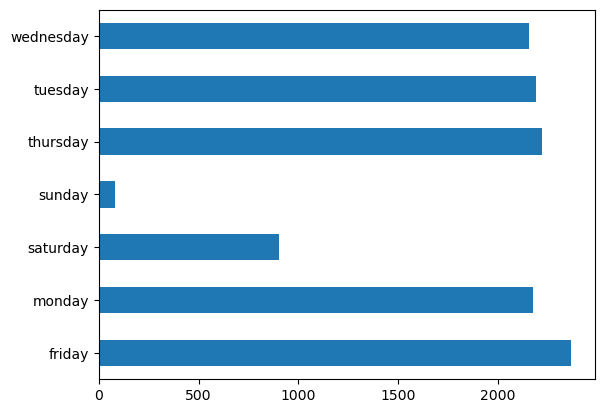

In [16]:
def dia_semana_atividade(atividade:str,df:pd.DataFrame)->dict:
    df1 = df.query(f'atividade =="{atividade}"')
    total_linhas = df1.shape[0]
     
    dic = {}
    dias_semana = df1['nome_dia'].unique().tolist()
    for dia in dias_semana:
        
        dic[dia]=len(df1.query(f'nome_dia =="{dia}"'))
        dic[dia] =round(dic[dia]/total_linhas,2)
        dic[dia] = int(dic[dia]*100)
        dia_ativo = {day: value for day, value in dic.items() if value > 5}
        
        df1['nome_dia'].value_counts().sort_index(ascending=True).plot(kind='barh')
        
    return dia_ativo

dia_arranque_motor = dia_semana_atividade(atividade='arranque_do_motor',df=df1)
    
display(dia_arranque_motor)
    

### quais os locais a maquina esteve desativada

In [17]:
df2 = df1.loc[(df1['hora'] > 20) | (df1['hora'] < 4)| (df1['atividade'] =='arranque_do_motor')]
display(df2.head(5))
unicos_lat_lon = df2['lat_lon'].unique()
display(unicos_lat_lon)
display(len(unicos_lat_lon))


,data_hora,atividade,gps_ativo,hora,nome_dia,lat,lon,lat_lon
21,2022-01-02 00:56:00,estado_activo,False,0,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868
22,2022-01-02 00:56:00,ligado,False,0,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868
23,2022-01-02 00:58:00,gsm_diagnostics-pt,False,0,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868
24,2022-01-02 00:58:00,primeiro_acerto_do_gps,True,0,sunday,-25.570830,-49.196113,-25.5708297|-49.1961126
25,2022-01-02 01:03:00,gsm_diagnostics-pt,True,1,sunday,-25.570800,-49.196139,-25.5708002|-49.1961389


array(['-25.5707737|-49.1960868', '-25.5708297|-49.1961126',
       '-25.5708002|-49.1961389', ..., '-26.6002381|-51.0978863',
       '-26.6026931|-51.0959506', '-26.6026995|-51.0959171'], dtype=object)

12622

### Grafico de Posicionamento x,y
Utilizando as coordenadas lat e lon e convertendo em um grafico de x,y para entender as regiões nas quais o equimamento esteve mais presente durante o periodo

<Axes: xlabel='lon', ylabel='lat'>

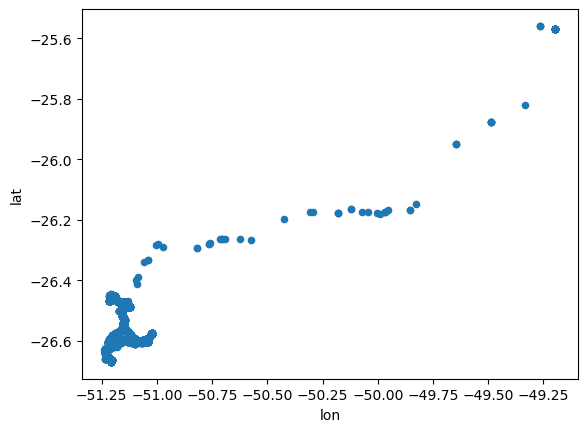

In [18]:
df1.plot.scatter(x='lon',y='lat')#, marker='o', color='blue', s=50, alpha=0.5)

# Add labels and title
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')
#plt.title('Scatter Plot of Latitude vs. Longitude')

# Show the plot
#plt.show()

<Axes: xlabel='lat', ylabel='lon'>

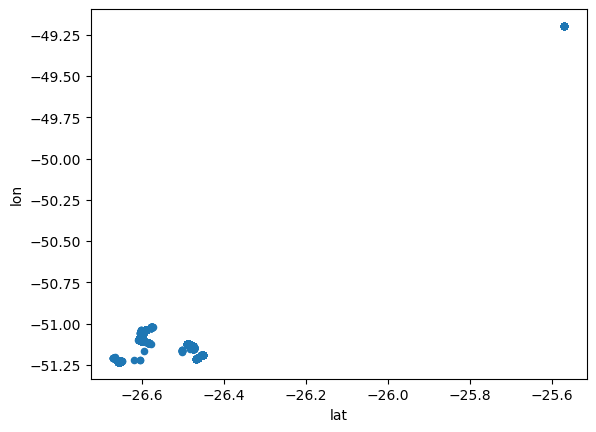

In [19]:
df2.plot.scatter(x='lat', y='lon')#, marker='o', color='blue', s=50, alpha=0.5)

### calcular a distancia a partir de pontos conhecidos


In [28]:
locais = [
    {'nome':'cant_1','lat':-26.603245,'lon':-51.097630,'raio':10,'cor':'#ffaa00'},
    {'nome':'cant_2','lat':-26.600224,'lon':-51.098041,'raio':10,'cor':'#ffaa00'},
    {'nome':'posto_calmon','lat':-26.599158,'lon':-51.096548,'raio':10,'cor':'#ffaa00'},
    {'nome':'posto_mite','lat':-26.472965,'lon':-51.140994,'raio':10,'cor':'#ffaa00'},
    {'nome':'pedreira_denilson','lat':-26.487208,'lon':-51.125129,'raio':10,'cor':'#ffaa00'},
]

df_locais = pd.DataFrame(locais)

display(df_locais)

,nome,lat,lon,raio,cor
0,cant_1,-26.603245,-51.097630,10,#ffaa00
1,cant_2,-26.600224,-51.098041,10,#ffaa00
2,posto_calmon,-26.599158,-51.096548,10,#ffaa00
3,posto_mite,-26.472965,-51.140994,10,#ffaa00
4,pedreira_denilson,-26.487208,-51.125129,10,#ffaa00


## grafico por mes!!

In [26]:
inicio=5
isinstance(inicio, datetime)

False